# MLP for Time Series Modeling


We roughly follow along with the tutorial here:
https://filippomb.github.io/python-time-series-handbook/notebooks/10/nn-reservoir-computing.html

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
import torch

In [4]:
# generating some time series data
class gen_synth_data:

    def __init__(self, t_train=300,t_test=200):
        self.t_train = t_train
        self.t_test = t_test
        self.t_length = self.t_train+self.t_test
        np.random.seed(31)
        self.t = np.arange(0,self.t_length)
        
    
    def build_custom_data(self):
        self.ar_scale = 10
        self.ar_comp = self.ar_scale*self.sim_ar(thetas = [-0.2,0.2])
        self.linear_comp = self.sim_lin(slope=0.01, intercept=0)
        self.seasonal_comp = self.sim_cyclic(amplitude = 8, frequency=(1/90), phase=0)
        self.noise = np.random.normal(0,1,self.t_length)
        self.poly_comp = self.sim_poly()
        self.data = self.ar_comp+self.linear_comp+self.seasonal_comp + self.noise + self.poly_comp

        self.data_train = self.data[0:self.t_train]
        self.data_test = self.data[self.t_train:]
    def build_data_no_ar(self):

        self.linear_comp = self.sim_lin(slope=0.01, intercept=0)
        self.seasonal_comp = self.sim_cyclic(amplitude = 8, frequency=(1/20), phase=0)

        self.data = self.linear_comp+self.seasonal_comp

    def plot_custom_data(self):
        
        plt.figure(figsize=(20,5))
        plt.plot(self.t, self.data)
        plt.title('Data')
    
        plt.figure(figsize=(20,5))
        plt.plot(self.t, self.ar_comp)
        plt.title('AR')
    
        plt.figure(figsize=(20,5))
        plt.plot(self.t, self.linear_comp)
        plt.title('linear')
    
        plt.figure(figsize=(20,5))
        plt.plot(self.t, self.seasonal_comp)
        plt.title('seasonal')

    
    def sim_cyclic(self, amplitude, frequency, phase):
        cyc = amplitude*np.sin(2*np.pi*frequency*(self.t + phase))
        return cyc
        
    def sim_lin(self, slope, intercept):
        lin_val = slope*self.t + intercept
        return lin_val
        
    def sim_ar(self, intercept = 0, thetas = [-0.9,0.9], noise_var = 0.3):
        self.ar_order = len(thetas) # by default it's 2; aka AR(2) process
        X = np.zeros(self.t_length)
        X[:self.ar_order] = intercept
        for i in range(self.ar_order, self.t_length):
            X[i] = np.sum(thetas*np.flip(X[(i-self.ar_order):i])) + np.random.normal(0, noise_var)
        return X

    def sim_poly(self, coeffs = [0, -0.001,0.000002]):
        X = np.zeros(self.t_length)
        for i in range(len(coeffs)):
            X = X + coeffs[i]*self.t**(i+1)
        return X

    def plot_data(self):
        plt.figure(figsize=(20,5))
        plt.plot(self.t, self.data)
        plt.title('Sim Time Series')
        plt.figure(figsize=(20,5))
        plt.scatter(self.t, self.data)
        plt.title('Sim Time Series')
        


In [5]:
data_obj = gen_synth_data()
data_obj.build_custom_data()

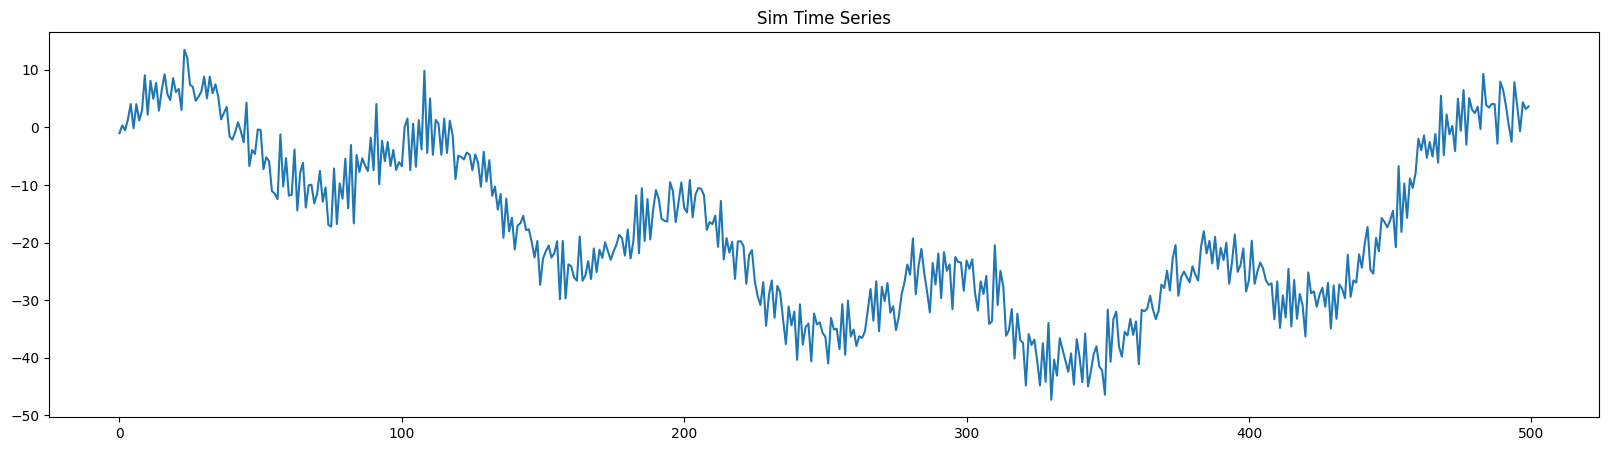

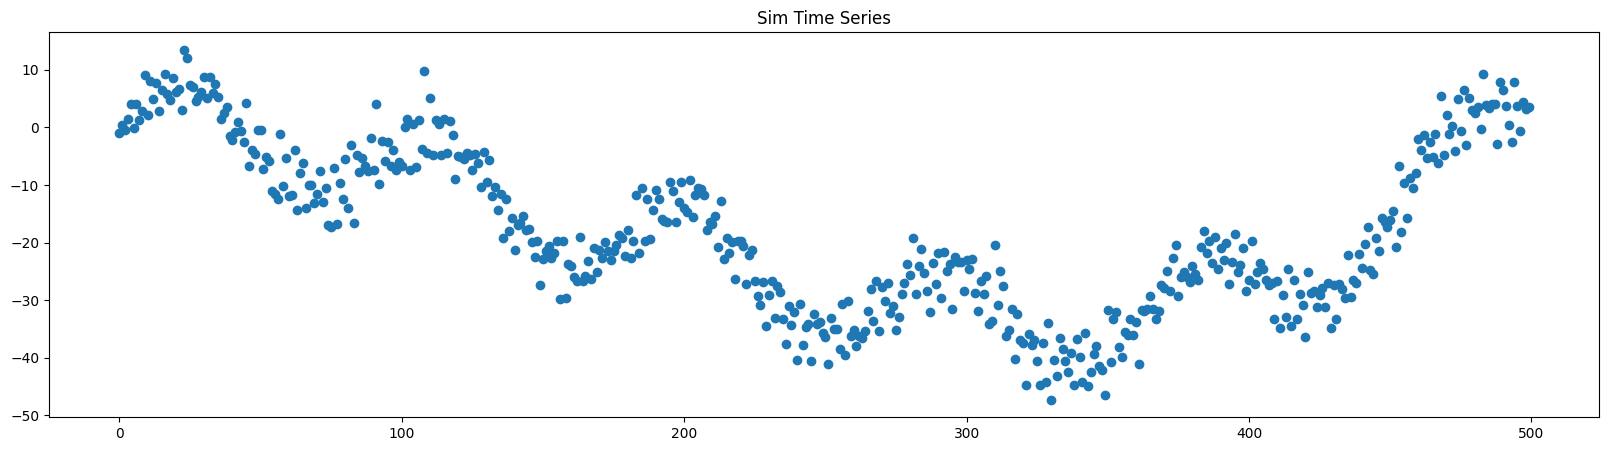

In [6]:
data_obj.plot_data()
# Cute little snakey boi

Now we create pairs of predictors and outcomes by taking many subsets of this time series, where for each subset we cut the time series in two and try to predict the latter part of the time series from the former part. For example I take a length 70 subset of my time series, and try to predict the last 20 values from the first 50 values--and I do this for every 70 length subset of my training data (which is in this case just the first 300 points of the time series).

Then we'll predict onto our test data, which is just the same operation but for the last 200 points of the time series. So basically we're taking a 70 point window of that, passing the first 50 points through our NN (which is data our NN has not been trained on) and then we get an output of 20 points that's a prediction of the next 20 points in our time series. We compare that to the 20 true points we have set aside in that cut of 70 from the test set. 

In [7]:
def create_windows(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

# Define window size and forecast horizon
window_size = 100
forecast_horizon = 20

X_train, y_train = create_windows(data_obj.data_train, window_size, forecast_horizon)
X_test, y_test = create_windows(data_obj.data_test, window_size, forecast_horizon)

The tutorial now normalizes the test and training data according to what we see in our training data, but in our case it's only by chance that the mean of the training data is even close to the mean of the test data. What happens if we don't normalize?

In [8]:
# Define and train the neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,20), activation='relu', solver='adam', max_iter=10000)
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 20), max_iter=10000)

In [9]:
# Predict on the test set
y_pred = mlp.predict(X_test)

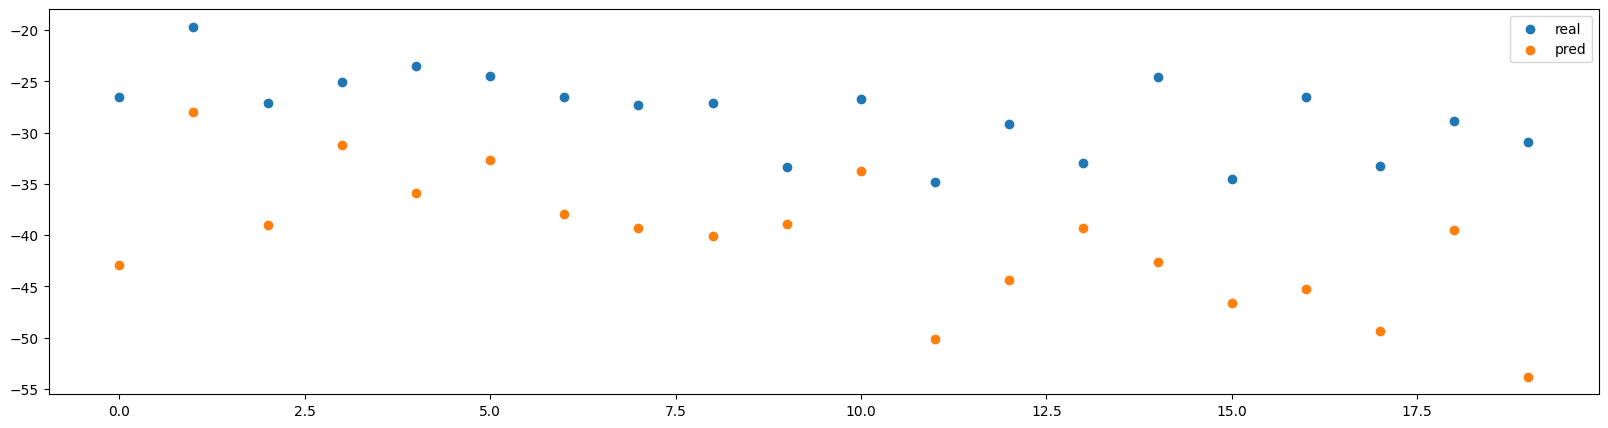

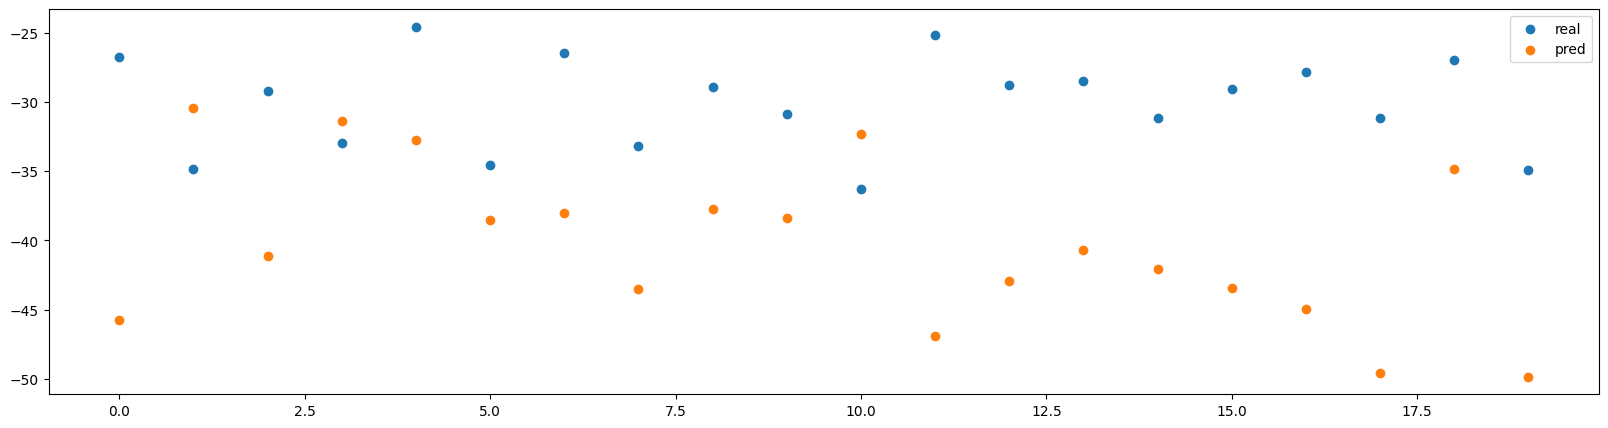

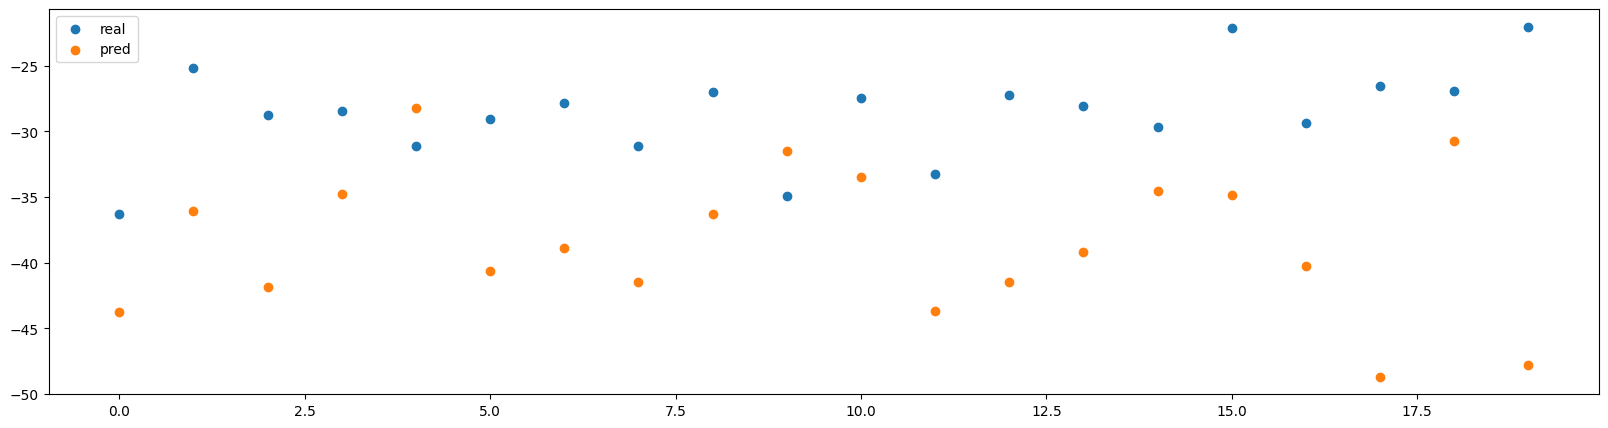

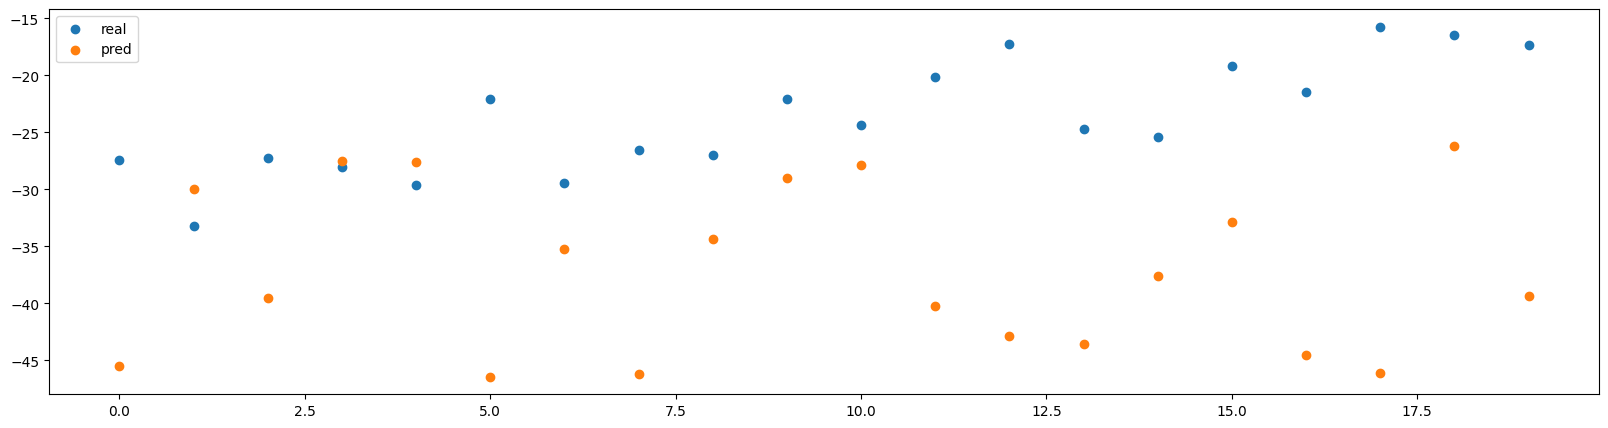

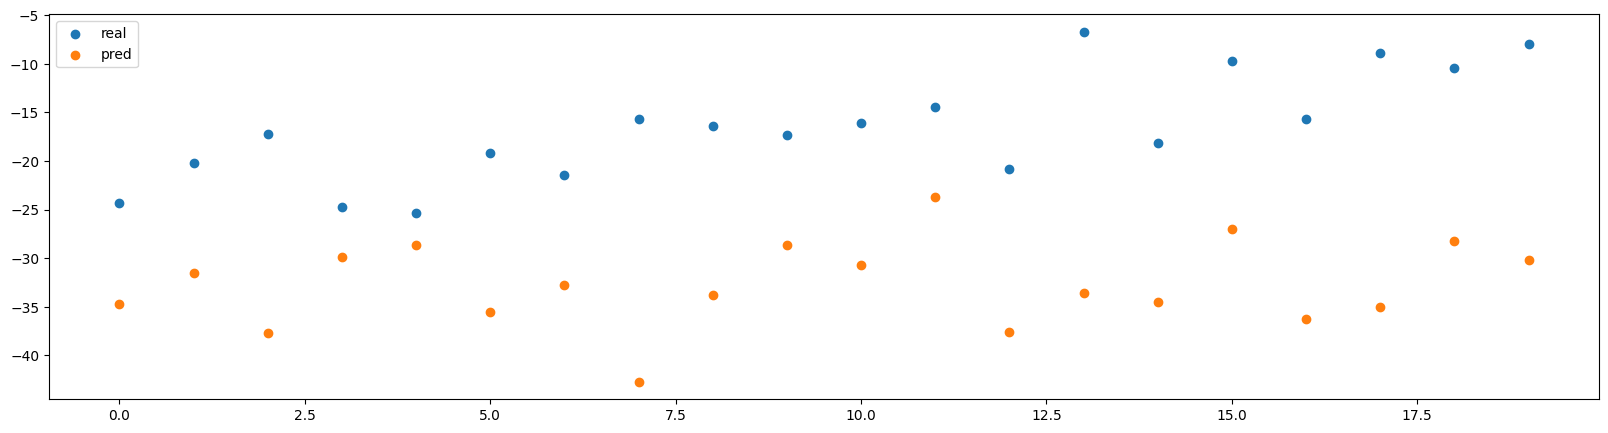

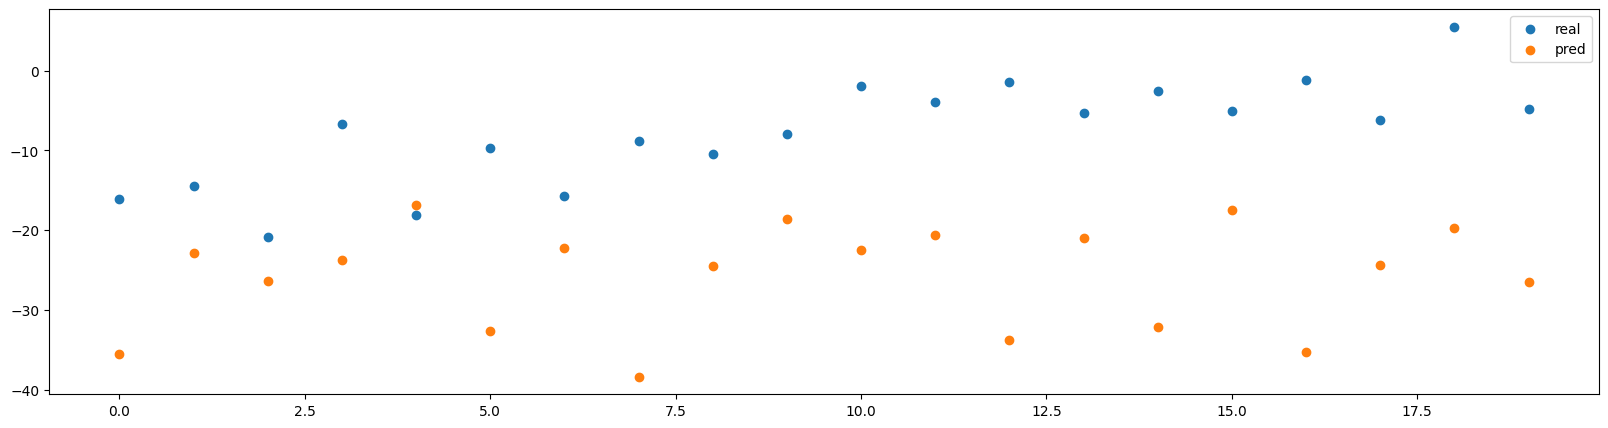

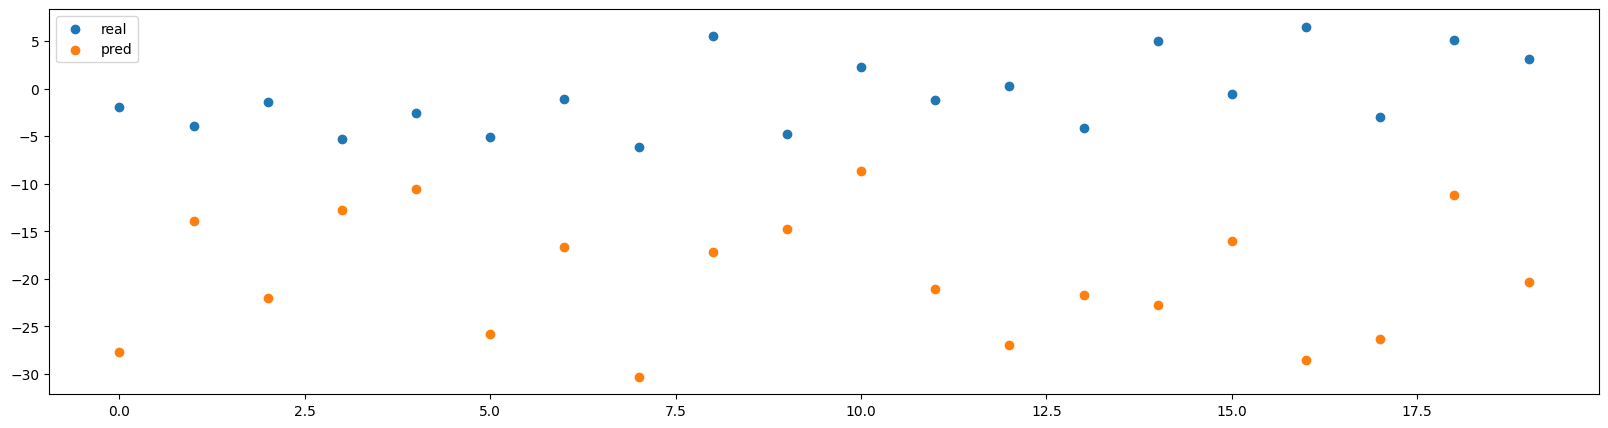

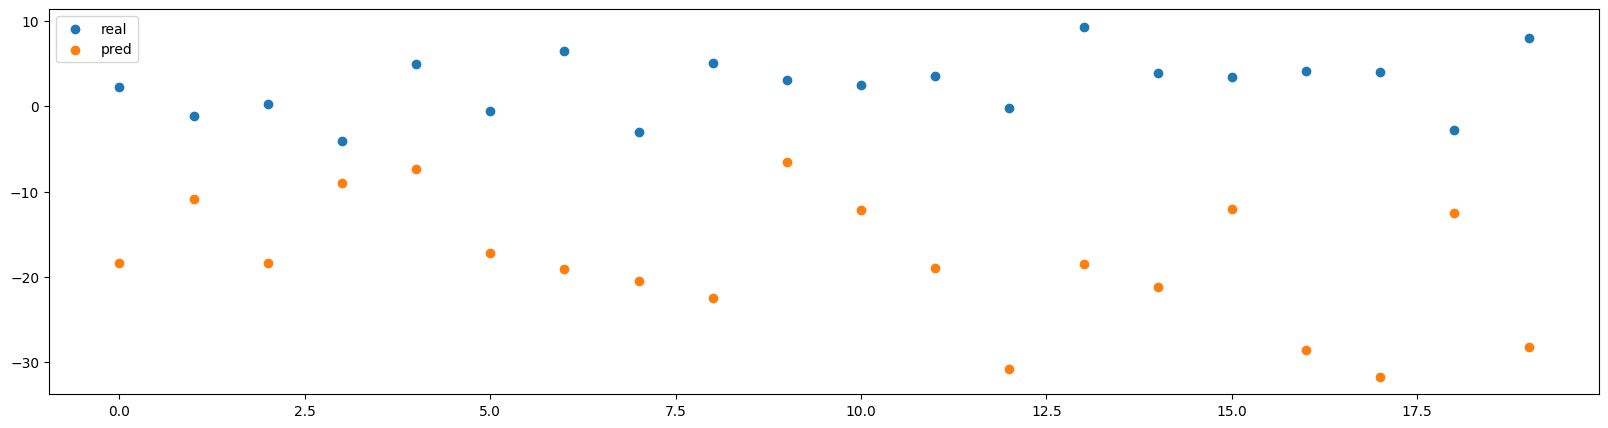

In [10]:
for i in range(0,80,10):
    plt.figure(figsize=(20,5))
    plt.scatter(np.arange(20), y_test[i], label='real')
    plt.scatter(np.arange(20), y_pred[i], label='pred')
    plt.legend()

In [12]:
residuals = y_test - y_pred


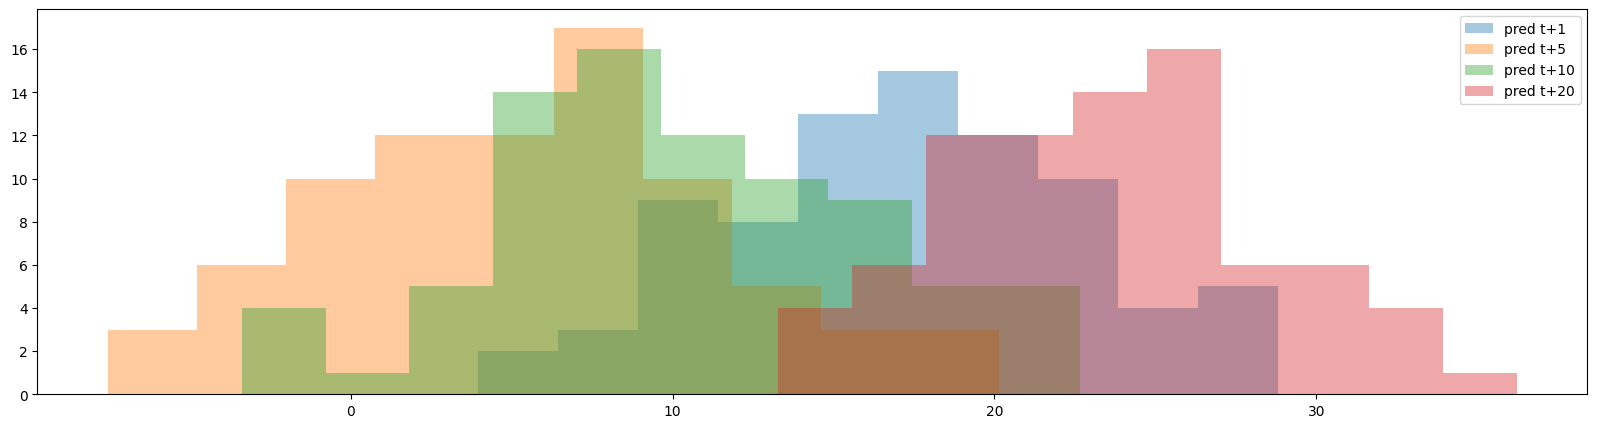

In [13]:
plt.figure(figsize=(20,5))
plt.hist(residuals[:,0], alpha=0.4,label='pred t+1')
plt.hist(residuals[:,4], alpha=0.4,label='pred t+5')
plt.hist(residuals[:,9], alpha=0.4,label='pred t+10')
plt.hist(residuals[:,19], alpha=0.4,label='pred t+20')
plt.legend()